# Demo for ranking protein-protein interface using Graph Convolution

## Project setup

In [ ]:
# Copying data and code from GitHub repository
!git clone https://github.com/withai/Demo-Ranking-protein-protein-interfaces-using-GNN.git
!mv Demo-Ranking-protein-protein-interfaces-using-GNN/* .
!rm -r Demo-Ranking-protein-protein-interfaces-using-GNN

## Import libraries

In [1]:
# Import PyTorch
import torch
import torch.backends.cudnn as cudnn
from torch.utils import data
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.utils import data
import torch.nn.init as init

# Import Neural Network layer
from nn import Dense

# Import utility functions
from dataset import Dataset
from sampler import CustomSampler
from train import train
from test import test

# Import libraries for graphing
import pandas as pd
import matplotlib
%matplotlib inline



## Run computation on GPU or CPU

In [2]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
torch.autograd.set_detect_anomaly(True)
cudnn.benchmark = True

## Define Graph Convolution layer

$$
h^{(l)}_i = \sigma \left(\mathbf{W}^{(l)}_c h^{(l-1)}_i +
    \frac{1}{|N_i^{(int)}|}\sum_{j \epsilon N_i^{(int)}} \mathbf{W}^{(l)}_{int} h^{(l-1)}_j \bigodot E_{ij} \right.  \left. + \frac{1}{|N_i^{(prot)}|}\sum_{j \epsilon N_i^{(prot)}} \mathbf{W}^{(l)}_{prot} h^{(l-1)}_j \bigodot E_{ij} + b^{(l)} \vphantom{\frac{1}{|N_i^{(neigh)}|}}\right)
$$


where for the layer $l$,  

$\mathbf{W}^{(l)}_c$ is the weight matrix for learning representations w.r.t central node,

$\mathbf{W}^{(l)}_{int}$ and $\mathbf{W}^{(l)}_{prot}$ are the weight matrix for learning representations w.r.t the neighbor nodes in the interface graph and the protein graph respectively,

$b^{(l)}$ is the bias vector, 

$h^{(l)}_i$ is the hidden node embedding of node $i$,

$N_i^{(int)}$ is the number of atoms surrounding node $i$ in the interface graph, 

$N_i^{(prot)}$ is the number of atoms surrounding node $i$ in the protein graph, 

$\sigma$  is the activation function, and

$E_{ij}$ is the value in the edge matrix between node $i$ and node $j$.

In [3]:
class GCN_layer(nn.Module):

    def __init__(self, v_feats, filters, dropout=0.1, bias=True, trainable=True, **kwargs):

        super(GCN_layer, self).__init__()

        self.v_feats = v_feats
        self.filters = filters
        self.dropout= dropout
        self.bias = bias
        self.trainable = trainable
        
        use_cuda = torch.cuda.is_available()
        self.device = torch.device("cuda:0" if use_cuda else "cpu")
        
        # Define non-linear function
        self.non_lin = nn.LeakyReLU()

        # Initialize dropout
        self.drop_layer = nn.Dropout(p=self.dropout)
       
        # Initialize learnable parameters
        self.Wvc = nn.Parameter(
                    init.kaiming_uniform_(
                        torch.randn(self.v_feats, self.filters, requires_grad=self.trainable))
                            .type(torch.float).to(self.device))  # (v_dims, filters)
        self.Wvn_int = nn.Parameter(
                        init.kaiming_uniform_(
                            torch.randn(self.v_feats, self.filters, requires_grad=self.trainable))
                                .type(torch.float).to(self.device))  # (v_dims, filters)
        self.Wvn_prot = nn.Parameter(
                        init.kaiming_uniform_(
                            torch.randn(self.v_feats, self.filters, requires_grad=self.trainable))
                                .type(torch.float).to(self.device))  # (v_dims, filters)
        self.bv = nn.Parameter(
                        torch.zeros(self.filters, requires_grad=self.trainable)
                            .type(torch.float).to(self.device))
        
        
    def forward(self, x):

        vertices, prot_indices, int_indices, prot_edges, int_edges = x

        # generate vertex signals
        Zc = torch.matmul(vertices, self.Wvc)  # (n_verts, filters)

        # create neighbor signals
        v_Wvn_int = torch.matmul(vertices, self.Wvn_int)  # (n_verts, filters)
        v_Wvn_prot = torch.matmul(vertices, self.Wvn_prot)  # (n_verts, filters)
        
        # Find participating neighbors of the interface and protein graph in Graph Convolution 
        int_part = torch.unsqueeze(int_indices > -1, 2).type(torch.float)
        prot_part = torch.unsqueeze(prot_indices > -1, 2).type(torch.float)

        # Find the number of neighbors per atom
        no_of_neighs_int = torch.sum(int_indices > -1, 1).unsqueeze(1).to(self.device).type(torch.float)
        no_of_neighs_prot = torch.sum(prot_indices > -1, 1).unsqueeze(1).to(self.device).type(torch.float)
        no_of_neighs_int[no_of_neighs_int == 0] = 1
        no_of_neighs_prot[no_of_neighs_prot == 0] = 1
        
        # Expand interface and neighborh edge matrices to allow scalar multiplication
        if(len(int_edges.size()) != 3):
            int_edges = torch.unsqueeze(int_edges, 2)
            prot_edges = torch.unsqueeze(prot_edges, 2)

        # Generate neighbor signals w.r.t the interface and protein graph
        Zn_inter = torch.sum(v_Wvn_int[int_indices] * int_part * int_edges, 1) / no_of_neighs_int
        Zn_prot = torch.sum(v_Wvn_prot[prot_indices] * prot_part * prot_edges, 1) / no_of_neighs_prot

        # Combine central and neighbor signals
        Z = Zc + Zn_inter + Zn_prot

        # Add bias
        if self.bias:
            Z += self.bv

        # Apply activation function
        h = self.non_lin(Z)

        # Apply dropout
        if self.dropout:
            h = self.drop_layer(h)


        return [h, prot_indices, int_indices, prot_edges, int_edges]

## Define Graph Neural network

In [4]:
class GNN(torch.nn.Module):
    """
        GCN + Normalize pool + L1-loss + Single label
    """
    def __init__(self):
        super(GNN, self).__init__()

        # Define neural network layers
        self.conv1 = GCN_layer(v_feats=11, filters=16, dropout=0.1)
        self.conv2 = GCN_layer(v_feats=16, filters=32, dropout=0.1)
        self.conv3 = GCN_layer(v_feats=32, filters=64, dropout=0.1)
        self.dense = Dense(in_dims=64, out_dims=1, nonlin="linear")

        # Define optimizer
        self.optimizer = optim.Adam(self.parameters(), lr=0.01, weight_decay=0.0001)

    def forward(self, x):
        
        # GCN layers
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x[0]
        # each row of x is now a feature vector.

        # Graph pooling
        x = torch.sum(x, 0).view(1, -1)
        x = F.normalize(x)

        # Dense layer
        x = self.dense(x)
        x = torch.squeeze(x, 1)

        return x

    def loss(self, output, target, reduction='mean'):
        # Define loss function
        return F.l1_loss(output, target, reduction=reduction)

## Initialize Graph Neural Network

In [5]:
model = GNN().to(device)

## Initialize PyTorch data loader and data sampler

In [6]:
dataset_path = "data"

# Train dataset generator 
train_dataset = Dataset(dataset_path, "train")
train_params = {'sampler': CustomSampler(batch_complexes = 2,
                                   decoys_per_complex = 50,
                                   dataset_path = dataset_path,
                                   dataset_cat = "train",
                                   random_sample = True),
          'num_workers': 0,
          'collate_fn' : lambda x: x[0]}
training_generator = data.DataLoader(train_dataset, **train_params)

# Test dataset generator
test_dataset = Dataset(dataset_path, "test")
test_params = {'sampler': CustomSampler(batch_complexes = 2,
                                   decoys_per_complex = 50,
                                   dataset_path = dataset_path,
                                   dataset_cat = "test"),
          'num_workers': 0,
          'collate_fn' : lambda x: x[0]}
test_generator = data.DataLoader(test_dataset, **test_params)

No. of train complexes: 3
No. of test complexes: 2


## Train model

In [7]:
epochs = 10
mini_batches_per_epoch = 30

loss = []

for epoch in range(0, epochs):
    
    loss_ = train(model, device, training_generator, model.optimizer, epoch, mini_batches_per_epoch)
    
    loss.append(loss_)
    
    print("Epoch " + str(epoch+1)+ " loss : " + str(loss_))
    

Epoch 1 loss : 1.5888511389493942
Epoch 2 loss : 0.3112610727548599
Epoch 3 loss : 0.3098634332418442
Epoch 4 loss : 0.23634936660528183
Epoch 5 loss : 0.5406454056501389
Epoch 6 loss : 0.4504081755876541
Epoch 7 loss : 0.21604672446846962
Epoch 8 loss : 0.4753987193107605
Epoch 9 loss : 0.30255285650491714
Epoch 10 loss : 0.14869529753923416


## Plot loss function

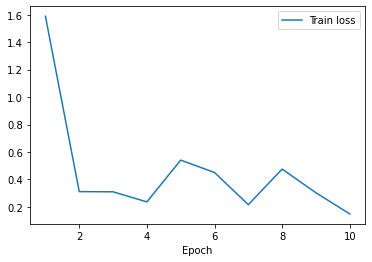

In [8]:
epoch_list = list(range(1, epochs+1))
epoch_losses = list(zip(epoch_list, loss))

loss_df = pd.DataFrame(epoch_losses, columns=["Epoch", "Train loss"])

lines = loss_df.plot.line(x="Epoch", y="Train loss")


## Test model

In [9]:
dockq_threshold = 0.65
top_ns = [1, 5, 10, 20, 50]

top_n_results = test(model, device, test_generator, dockq_threshold, top_ns)



print("Number of complexes in the test set for which the decoys above a DockQ value of " + str(dockq_threshold) + 
      " are ranked in the top-n")
print("Total number of complexes in test set: " + str(len(test_dataset)) + "\n")
for i in range(len(top_ns)):
    print("Top " + str(top_ns[i]) + " : " + str(top_n_results[i]) + " complexes")
    

Number of complexes in the test set for which the decoys above a DockQ value of 0.65 are ranked in the top-n
Total number of complexes in test set: 2

Top 1 : 2 complexes
Top 5 : 2 complexes
Top 10 : 2 complexes
Top 20 : 2 complexes
Top 50 : 2 complexes
